<a href="https://colab.research.google.com/github/sajan-sarker/PyTorch_Practice_Codes/blob/main/PyTorch_Practice_3_MLP_Training_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo

In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import random
import warnings
from itertools import product
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [ ]:
# checking for available GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:",device)

Using GPU: Tesla T4


In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
X = pd.read_csv("/content/drive/MyDrive/web-attack-detection/datasets/safe_reduced_and_malicious_balanced/X_test.csv")
y = pd.read_csv("/content/drive/MyDrive/web-attack-detection/datasets/safe_reduced_and_malicious_balanced/y_test.csv")
df = pd.concat([X, y], axis=1)
col = df.columns
df = df.sample(n=2500, random_state=42)
df.shape

(1500, 32)

In [ ]:
y = df[['Attack Type', 'status']]
X = df.drop(columns=['Attack Type', 'status'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create Custom Dataset Class

In [ ]:
class MultiLabelDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X.values)
    self.y_multi = torch.LongTensor(y['Attack Type'].values)
    self.y_binary = torch.FloatTensor(y['status'].values).unsqueeze(1)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y_multi[idx], self.y_binary[idx]

# Create MLP class

In [ ]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MultiLayerPerceptron, self).__init__()
    self.layers = nn.Sequential(
        # first hidden layer
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_size),
        nn.Dropout(0.3),
        # second hidden layer
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_size),
        nn.Dropout(0.2),
        # third hidden layer
        nn.Linear(hidden_size, hidden_size//2),
        nn.ReLU(),
        nn.BatchNorm1d(hidden_size//2),
        nn.Dropout(0.2)
    )
    self.multi_output = nn.Linear(hidden_size//2, output_size)
    self.binary_output = nn.Sequential(
        nn.Linear(hidden_size//2, 1),
        nn.Sigmoid()
    )

  def forward(self, X):
    features = self.layers(X)
    multi_class_out = self.multi_output(features)
    binary_out = self.binary_output(features)
    return multi_class_out, binary_out

# model training function

In [ ]:
def train_model(model, train_loader, val_loader, criterion_multi, criterion_binary, optimizer, scheduler, num_epochs, patience=5):
  train_losses = []
  val_losses = []
  train_acc_multi = []
  train_acc_binary = []
  val_acc_multi = []
  val_acc_binary = []

  best_val_loss = float('inf')
  epochs_no_improve = 0
  min_delta = 0.001

  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_multi = 0
    correct_binary = 0
    total_samples = 0

    for batch_X, batch_y_multi, batch_y_binary in train_loader:
      batch_X, batch_y_multi, batch_y_binary = batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

      # forward pass
      pred_multi, pred_binary = model(batch_X)

      # calculate loss
      loss_multi = criterion_multi(pred_multi, batch_y_multi)
      loss_binary = criterion_binary(pred_binary, batch_y_binary)
      loss = loss_multi + loss_binary

      # backward pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

      # calculate total epoch loss
      total_loss += loss.item()
      _, predicted_multi = torch.max(pred_multi.data, 1)
      predicted_binary = (pred_binary > 0.5).float()

      correct_multi += (predicted_multi == batch_y_multi).sum().item()
      correct_binary += (predicted_binary == batch_y_binary).sum().item()
      total_samples += batch_y_multi.size(0)

    model.eval()
    val_loss = 0
    val_correct_multi = 0
    val_correct_binary = 0
    val_samples = 0

    with torch.no_grad():
      for batch_X, batch_y_multi, batch_y_binary in val_loader:
        batch_X, batch_y_multi, batch_y_binary =  batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

        pred_multi, pred_binary = model(batch_X)

        loss_multi = criterion_multi(pred_multi, batch_y_multi)
        loss_binary = criterion_binary(pred_binary, batch_y_binary)
        val_loss += (loss_multi + loss_binary).item()

        _, predicted_multi = torch.max(pred_multi.data, 1)
        predicted_binary = (pred_binary > 0.5).float()

        val_correct_multi += (predicted_multi == batch_y_multi).sum().item()
        val_correct_binary += (predicted_binary == batch_y_binary).sum().item()
        val_samples += batch_y_multi.size(0)

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_acc_multi.append(correct_multi / total_samples)
    train_acc_binary.append(correct_binary / total_samples)
    val_acc_multi.append(val_correct_multi / val_samples)
    val_acc_binary. append(val_correct_binary / val_samples)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Multi Acc: {val_acc_multi[-1]:.4f}, Binary Acc: {val_acc_binary[-1]:.4f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss - min_delta:
      best_val_loss = avg_val_loss
      epochs_no_improve = 0
      torch.save(model.state_dict(), 'mlp_model.pth')
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience and epoch >=10:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

  return train_losses, val_losses, train_acc_multi, train_acc_binary, val_acc_multi, val_acc_binary

# Metrics Plot

In [ ]:
def plot_metrics(train_losses, val_losses, train_acc_multi, val_acc_multi, train_acc_binary, val_acc_binary):
  plt.figure(figsize=(15, 5))

  plt.subplot(1,2,1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('Training and validation Loss')
  plt.xlabel("Epochs")
  plt.ylabel('Losses')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(train_acc_multi, label='Train Multi-class acc')
  plt.plot(val_acc_multi, label='Val Multi-class acc')
  plt.plot(train_acc_binary, label='Train Binary acc')
  plt.plot(val_acc_binary, label='Val Binary acc')
  plt.title('Training and validation Accuracy')
  plt.xlabel("Epochs")
  plt.ylabel('Losses')
  plt.legend()

  plt.tight_layout()
  plt.show()

# Hyper parameter tuning

In [ ]:
def hyperparameter_tuning(input_size, train_dataset, val_dataset):
  param_grid = {
      'lr': [0.01, 0.001, 0.0001],
      'hidden_size': [128, 256, 512],
      'batch_size': [16, 32, 64]
  }

  best_val_acc = 0
  best_params = None

  for lr, hidden_size, batch_size in product(param_grid['lr'], param_grid['hidden_size'], param_grid['batch_size']):
    print(f"\nTuning: lr={lr}, hidden_size={hidden_size}, batch_size={batch_size}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = MultiLayerPerceptron(input_size, hidden_size, output_size).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion_multi = nn.CrossEntropyLoss()
    criterion_binary = nn.BCELoss()

    metrics = train_model(model, train_loader, val_loader, criterion_multi, criterion_binary, optimizer, scheduler, num_epochs=20, patience=5)
    avg_val_acc = (metrics[4][-1] + metrics[5][-1]) / 2

    if avg_val_acc > best_val_acc:
      best_val_acc = avg_val_acc
      best_params = {
          'lr': lr,
          'hidden_size': hidden_size,
          'batch_size': batch_size
      }
  print(f"\nBest Parameters: {best_params}, Best Validation Accuracy: {best_val_acc:.4f}")
  return best_params


# Testset evaluation

In [ ]:
def evaluate_model(model, test_loader):
  model.eval()  # enable evaluation mode
  correct_multi = 0
  correct_binary = 0
  total = 0

  with torch.no_grad():
    for batch_X, batch_y_multi, batch_y_binary in test_loader:
        batch_X, batch_y_multi, batch_y_binary =  batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

        pred_multi, pred_binary = model(batch_X)

        _, predicted_multi = torch.max(pred_multi, 1) # modified remove .data
        predicted_binary = (pred_binary > 0.5).float()

        correct_multi += (predicted_multi == batch_y_multi).sum().item()
        correct_binary += (predicted_binary == batch_y_binary).sum().item()
        total += batch_y_multi.size(0)

  print(f"Test Multi-class Accuracy: {correct_multi/total:.4f}")
  print(f"Test Binary Accuracy: {correct_binary/total:.4f}")

Training

In [ ]:
train_dataset = MultiLabelDataset(X_train, y_train)
val_dataset = MultiLabelDataset(X_val, y_val)
test_dataset = MultiLabelDataset(X_test, y_test)

# parameter tuning codes....



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# model parameters
input_size = X_train.shape[1]
hidden_size = 256
output_size = len(np.unique(y_train['Attack Type']))

model = MultiLayerPerceptron(input_size, hidden_size, output_size).to(device)
criterion_multi = nn.CrossEntropyLoss()
criterion_binary = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
summary(model, input_size=(1,input_size))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [1, 7]                    --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Linear: 2-1                       [1, 256]                  7,936
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─BatchNorm1d: 2-3                  [1, 256]                  512
│    └─Dropout: 2-4                      [1, 256]                  --
│    └─Linear: 2-5                       [1, 256]                  65,792
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─BatchNorm1d: 2-7                  [1, 256]                  512
│    └─Dropout: 2-8                      [1, 256]                  --
│    └─Linear: 2-9                       [1, 128]                  32,896
│    └─ReLU: 2-10                        [1, 128]                  --
│    └─BatchNorm1d: 2-11                 [1, 128]                  256
│

In [ ]:
%%time
num_epochs = 50
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
metrics = train_model(model, train_loader, val_loader, criterion_multi, criterion_binary, optimizer, scheduler, num_epochs)


Epoch [1/50], Train Loss: 0.2173, Val Loss: 0.5145, Val Multi Acc: 0.9289, Binary Acc: 0.9289
Epoch [2/50], Train Loss: 0.2708, Val Loss: 0.4914, Val Multi Acc: 0.9289, Binary Acc: 0.9244
Epoch [3/50], Train Loss: 0.2301, Val Loss: 0.5015, Val Multi Acc: 0.9289, Binary Acc: 0.9244
Epoch [4/50], Train Loss: 0.2431, Val Loss: 0.5124, Val Multi Acc: 0.9244, Binary Acc: 0.9244
Epoch [5/50], Train Loss: 0.2387, Val Loss: 0.4957, Val Multi Acc: 0.9289, Binary Acc: 0.9244
Epoch [6/50], Train Loss: 0.2386, Val Loss: 0.4900, Val Multi Acc: 0.9289, Binary Acc: 0.9244
Epoch [7/50], Train Loss: 0.2352, Val Loss: 0.5023, Val Multi Acc: 0.9289, Binary Acc: 0.9289
Epoch [8/50], Train Loss: 0.2391, Val Loss: 0.5036, Val Multi Acc: 0.9289, Binary Acc: 0.9289
Epoch [9/50], Train Loss: 0.2252, Val Loss: 0.5019, Val Multi Acc: 0.9289, Binary Acc: 0.9244
Epoch [10/50], Train Loss: 0.2583, Val Loss: 0.5131, Val Multi Acc: 0.9289, Binary Acc: 0.9244
Epoch [11/50], Train Loss: 0.2292, Val Loss: 0.4940, Val Mu

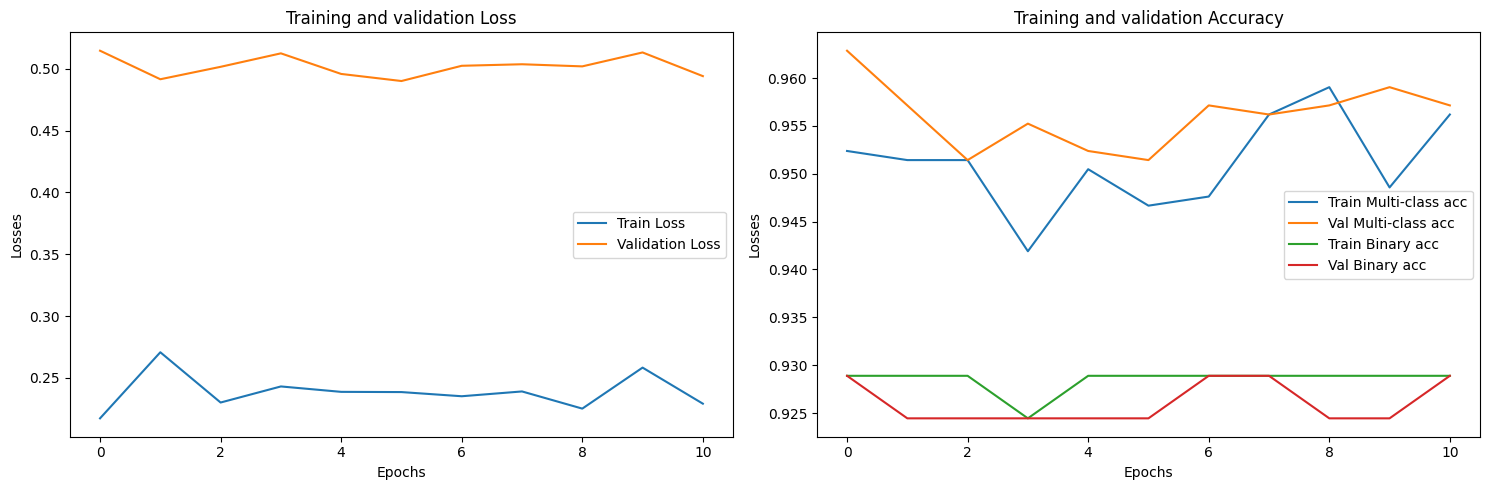

In [ ]:
plot_metrics(*metrics)

In [ ]:
evaluate_model(model, test_loader)

Test Multi-class Accuracy: 0.9511
Test Binary Accuracy: 0.9556


In [ ]:
%%time
hyperparameter_tuning(input_size, train_dataset, val_dataset)


Tuning: lr=0.01, hidden_size=128, batch_size=16
Epoch [1/20], Train Loss: 1.6250, Val Loss: 1.1070, Val Multi Acc: 0.6978, Binary Acc: 0.9156
Epoch [2/20], Train Loss: 1.0838, Val Loss: 0.8882, Val Multi Acc: 0.8356, Binary Acc: 0.9244
Epoch [3/20], Train Loss: 1.0341, Val Loss: 0.7512, Val Multi Acc: 0.8444, Binary Acc: 0.9422
Epoch [4/20], Train Loss: 0.8670, Val Loss: 0.7652, Val Multi Acc: 0.7511, Binary Acc: 0.9244
Epoch [5/20], Train Loss: 0.8947, Val Loss: 0.7220, Val Multi Acc: 0.7733, Binary Acc: 0.9111
Epoch [6/20], Train Loss: 0.8394, Val Loss: 0.6661, Val Multi Acc: 0.8711, Binary Acc: 0.9422
Epoch [7/20], Train Loss: 0.8009, Val Loss: 0.6509, Val Multi Acc: 0.8978, Binary Acc: 0.9200
Epoch [8/20], Train Loss: 0.7623, Val Loss: 0.5581, Val Multi Acc: 0.9067, Binary Acc: 0.9378
Epoch [9/20], Train Loss: 0.7531, Val Loss: 0.6056, Val Multi Acc: 0.9067, Binary Acc: 0.9333
Epoch [10/20], Train Loss: 0.6710, Val Loss: 0.6800, Val Multi Acc: 0.8489, Binary Acc: 0.9200
Epoch [11/